In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS
from src.verify import check_MC
from src.utils import same_seed, sample_mask, create_mask, print_counter_MC
from src.nonconvex import create_loss_fn
from src.search import create_search_proj_fn, create_search_loss_fn, search
torch.set_printoptions(precision=4)

In [2]:
def plot_loss(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss    = [loss[0] for loss in losses]
    diff    = [loss[1] for loss in losses]
    grad_X  = [loss[2] for loss in losses]
    hess_X  = [loss[3] for loss in losses]
    f_X     = [loss[4] for loss in losses]
    f_Z     = [loss[5] for loss in losses]
    trans   = [loss[6] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(f_X, label=r'f(X)')
    ax[2][1].plot(f_Z, label=r'f(Z)')

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(Z)-f(X)$", fontsize=30)
    ax[0][1].set_title(r"$f(Z)-f(X)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|XX^T-ZZ^T\|_F$", fontsize=30)
    ax[1][1].set_title(r"$-\|XX^T-ZZ^T\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    # ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel("Function Value", fontsize=30)
    ax[2][1].set_title("Function Value vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].legend(loc='best')
    ax[2][1].grid()

In [3]:
def compute_X_Z_e(variables, top_k, n, r, mu, e_norm, loss_type='MC_max', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1e-2, -1e2)):
    parameters = {}
    for name, val  in variables.items():
        if name == 'X':
            X = torch.normal(0.0, torch.ones((n, r))).requires_grad_()
            parameters['X'] = X
        elif name == 'Z':
            if val is None:
                Z = torch.normal(0.0, torch.ones((n, r))).requires_grad_()
                parameters['Z'] = Z
            else:
                Z = val
        elif name == 'e':
            if val is None:
                e = torch.zeros((n, n), requires_grad=True, dtype=torch.float32)
                parameters['e'] = e
            else:
                e = val
        elif name == 'P':
            if val is None:
                P = torch.rand((n, n), requires_grad=True)
                parameters['P'] = P
            else:
                P = val
    loss_fn = create_loss_fn(
        'MC_PSD', 
        P = P.detach(),
        Z = Z.detach(),
        e = e.detach(),
        top_k = top_k,
    )
    criterion = create_search_loss_fn(
        loss_fn, 
        loss_type, 
        P = P.detach(),
        Z = Z.detach(),
        e = e.detach(),
    )
    proj_fn = create_search_proj_fn(
        'MC', 
        mu = mu, 
        max_norm = e_norm
    )
    proj_fn(**parameters)
    losses = search(
        parameters,
        criterion,
        proj_fn,
        optim,
        iters,
        lr,
        min_lr,
        lr_sched,
        T,
        trans_bound,
    )
    
    return parameters, losses
    

==================== Search for (X, Z) ====================
=> # of samples (m)         =         12
=> Total loss               =  -1.36e-01
=> f(Z) - f(X)              =  -1.51e-01
=> |gradient(X)|            =   5.56e-02
=> -lambda_min(hessian(X))  =   4.73e-02
=> |XX^T-ZZ^T|_F            =  -2.56e+00
=> X =
tensor([[ 1.8730e-01],
        [-1.3015e-07],
        [-6.9575e-01],
        [-4.5486e-01],
        [-6.9575e-01]])
=> Z =
tensor([[-4.4319e-01],
        [ 3.2839e-07],
        [ 9.4969e-01],
        [-9.4969e-01],
        [-5.0428e-01]])
=> P =
tensor([[1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0.]])
=> Mask =
tensor([[1, 1, 1, 1, 0],
        [1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0]])


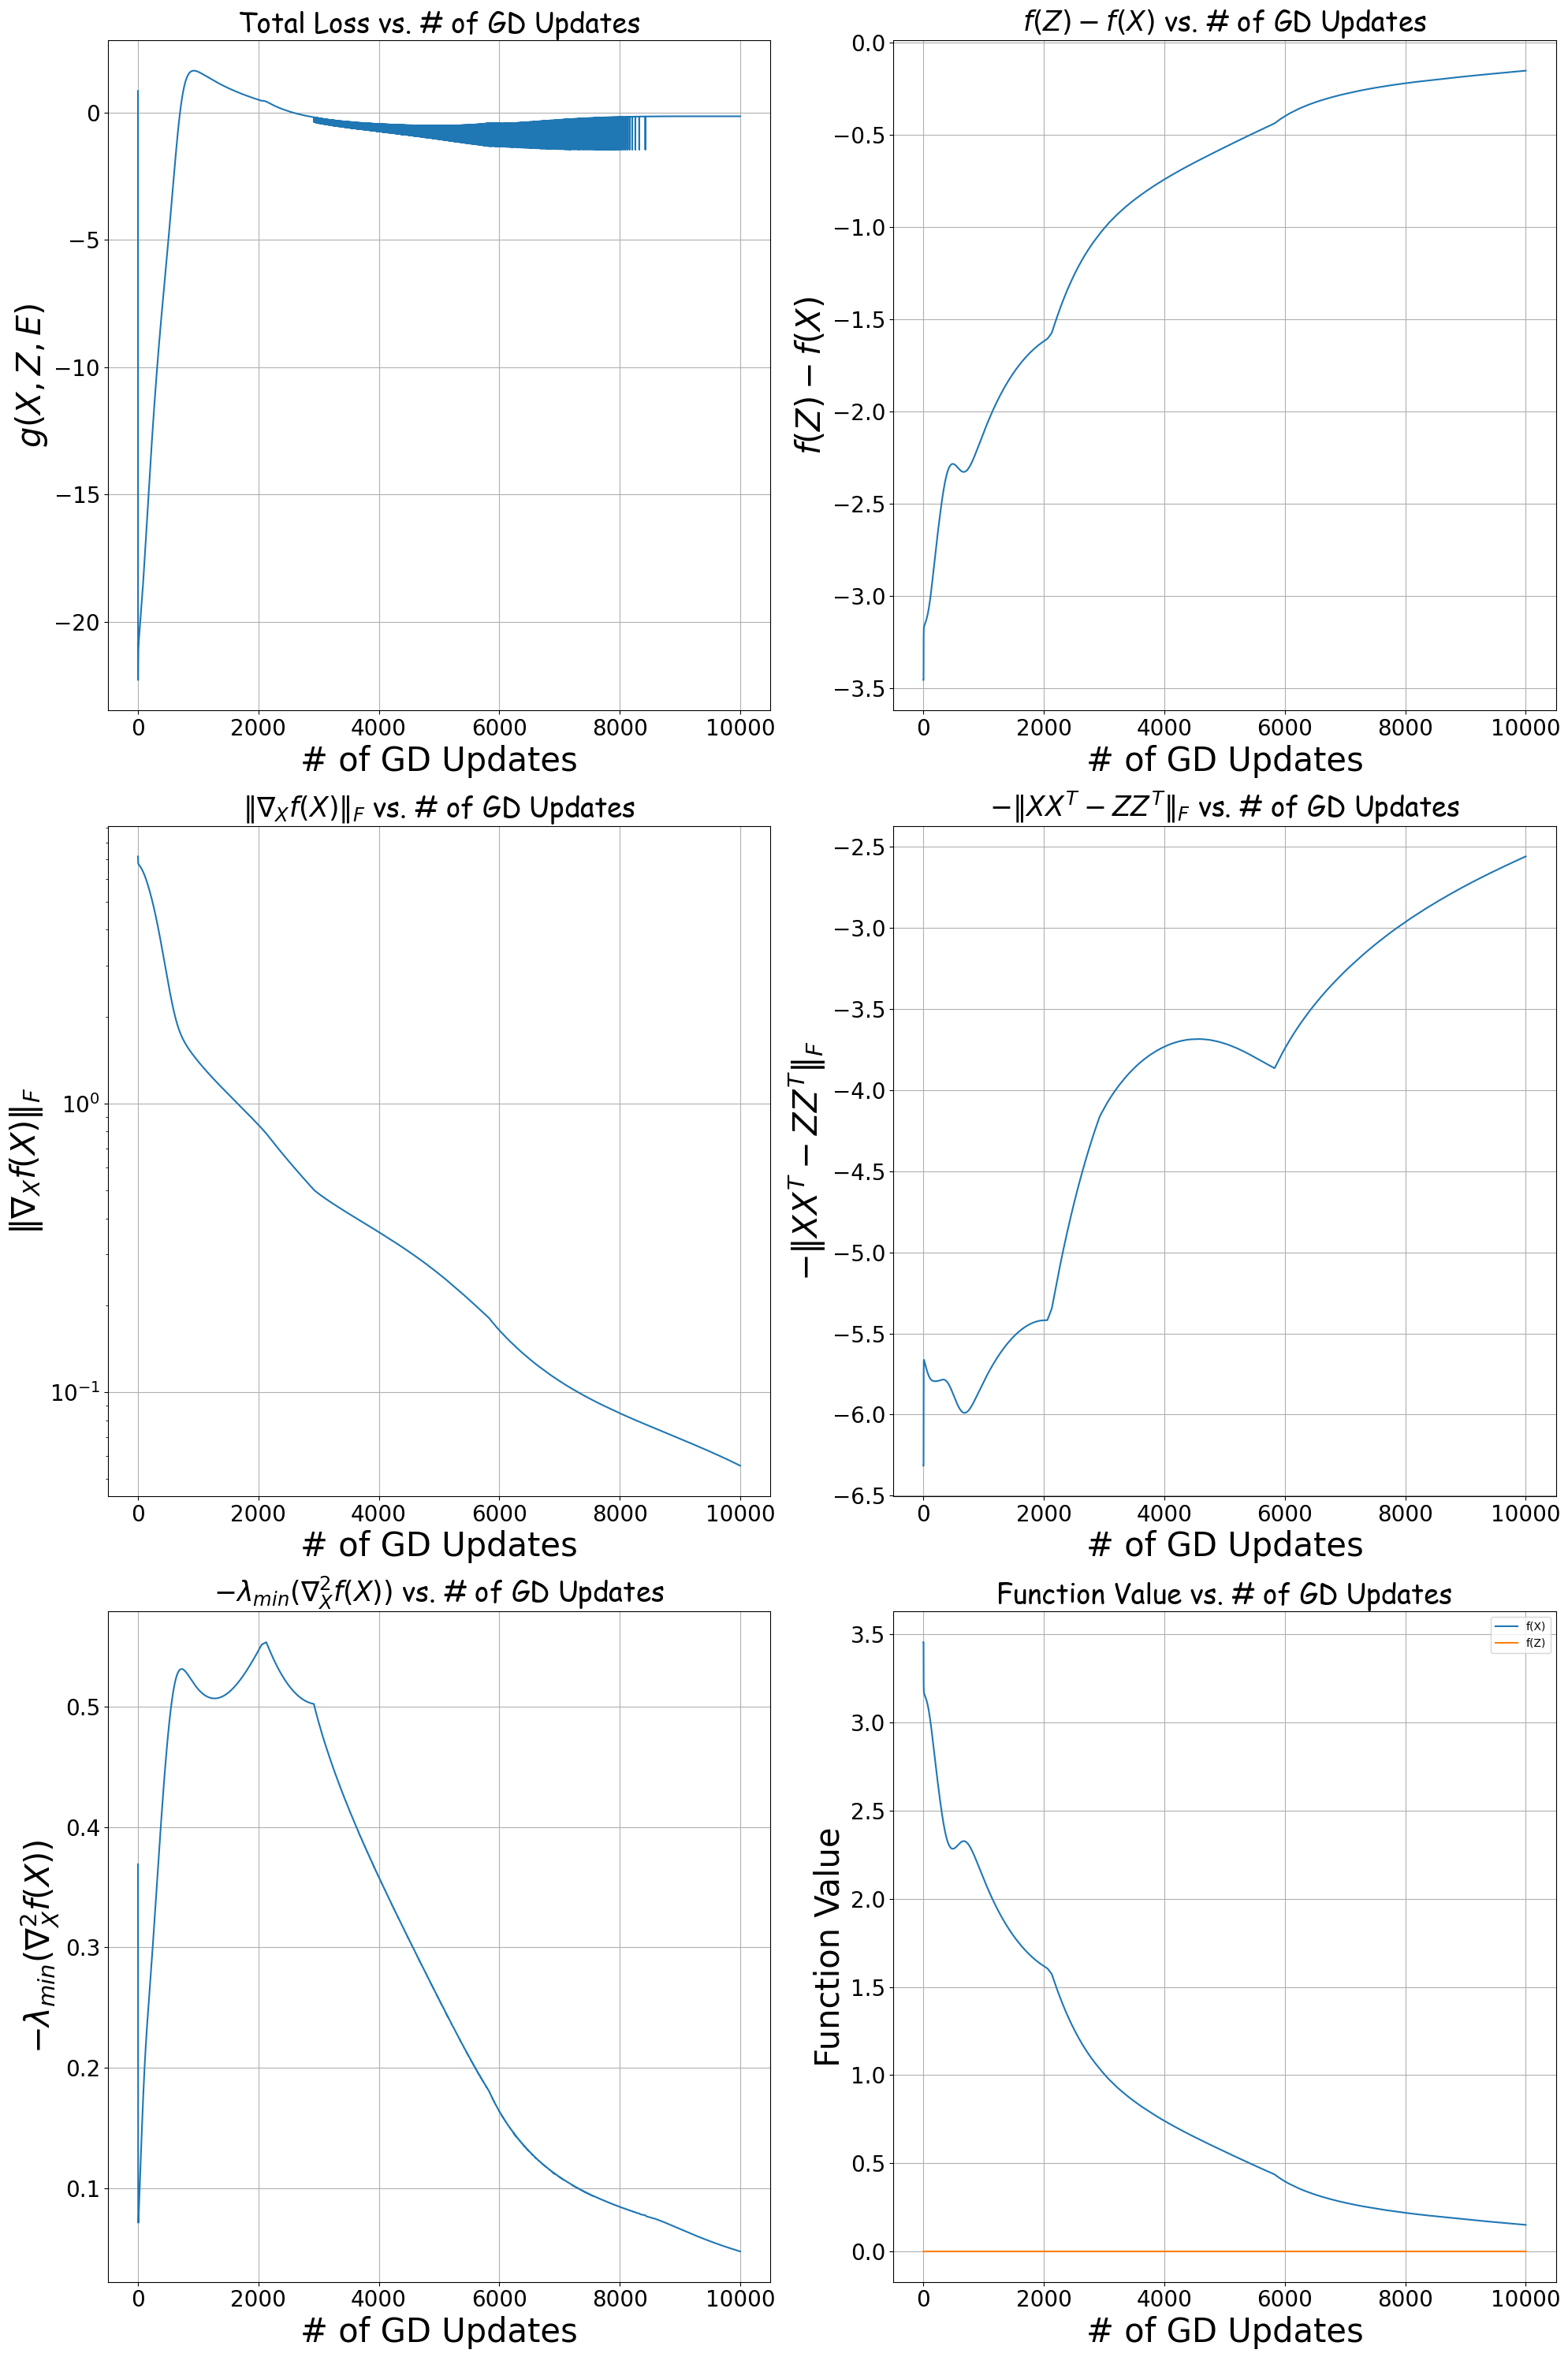

In [4]:
######## Search for (X, Z) ########
n           = 5
r           = 1
p           = 0.5
mu          = 2   # [1, n/r]
e_norm      = 1e-9
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e2)
top_k       = int(n * n * p)

same_seed(0)
P = create_mask(torch.tensor(sample_mask(n, n, p)), top_k)
P = P.to(torch.float32)
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "P": P,
}
parameters, losses = compute_X_Z_e(
    variables,
    top_k,
    n, 
    r,  
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound
)
print_counter_MC("Search for (X, Z)", top_k, parameters, losses, P=P)
plot_loss(losses)

lr=0.000500, diff=-8.10, dist=-4.16, trans=-6.32, max=13.57, coeff=(11.08,2.80):   0%|          | 0/10000 [00:00<?, ?it/s]

==================== Search for (X, Z) ====================
=> # of samples (m)         =         20
=> Total loss               =  -7.26e-01
=> f(Z) - f(X)              =  -4.62e+00
=> |gradient(X)|            =   1.73e+00
=> -lambda_min(hessian(X))  =   1.27e+00
=> |XX^T-ZZ^T|_F            =  -6.31e+00
=> X =
tensor([[ 0.7711],
        [ 0.7698],
        [-0.8030],
        [-0.8865],
        [-0.0088]])
=> Z =
tensor([[-1.2267],
        [ 1.1957],
        [ 1.1612],
        [-1.1869],
        [-0.2342]])


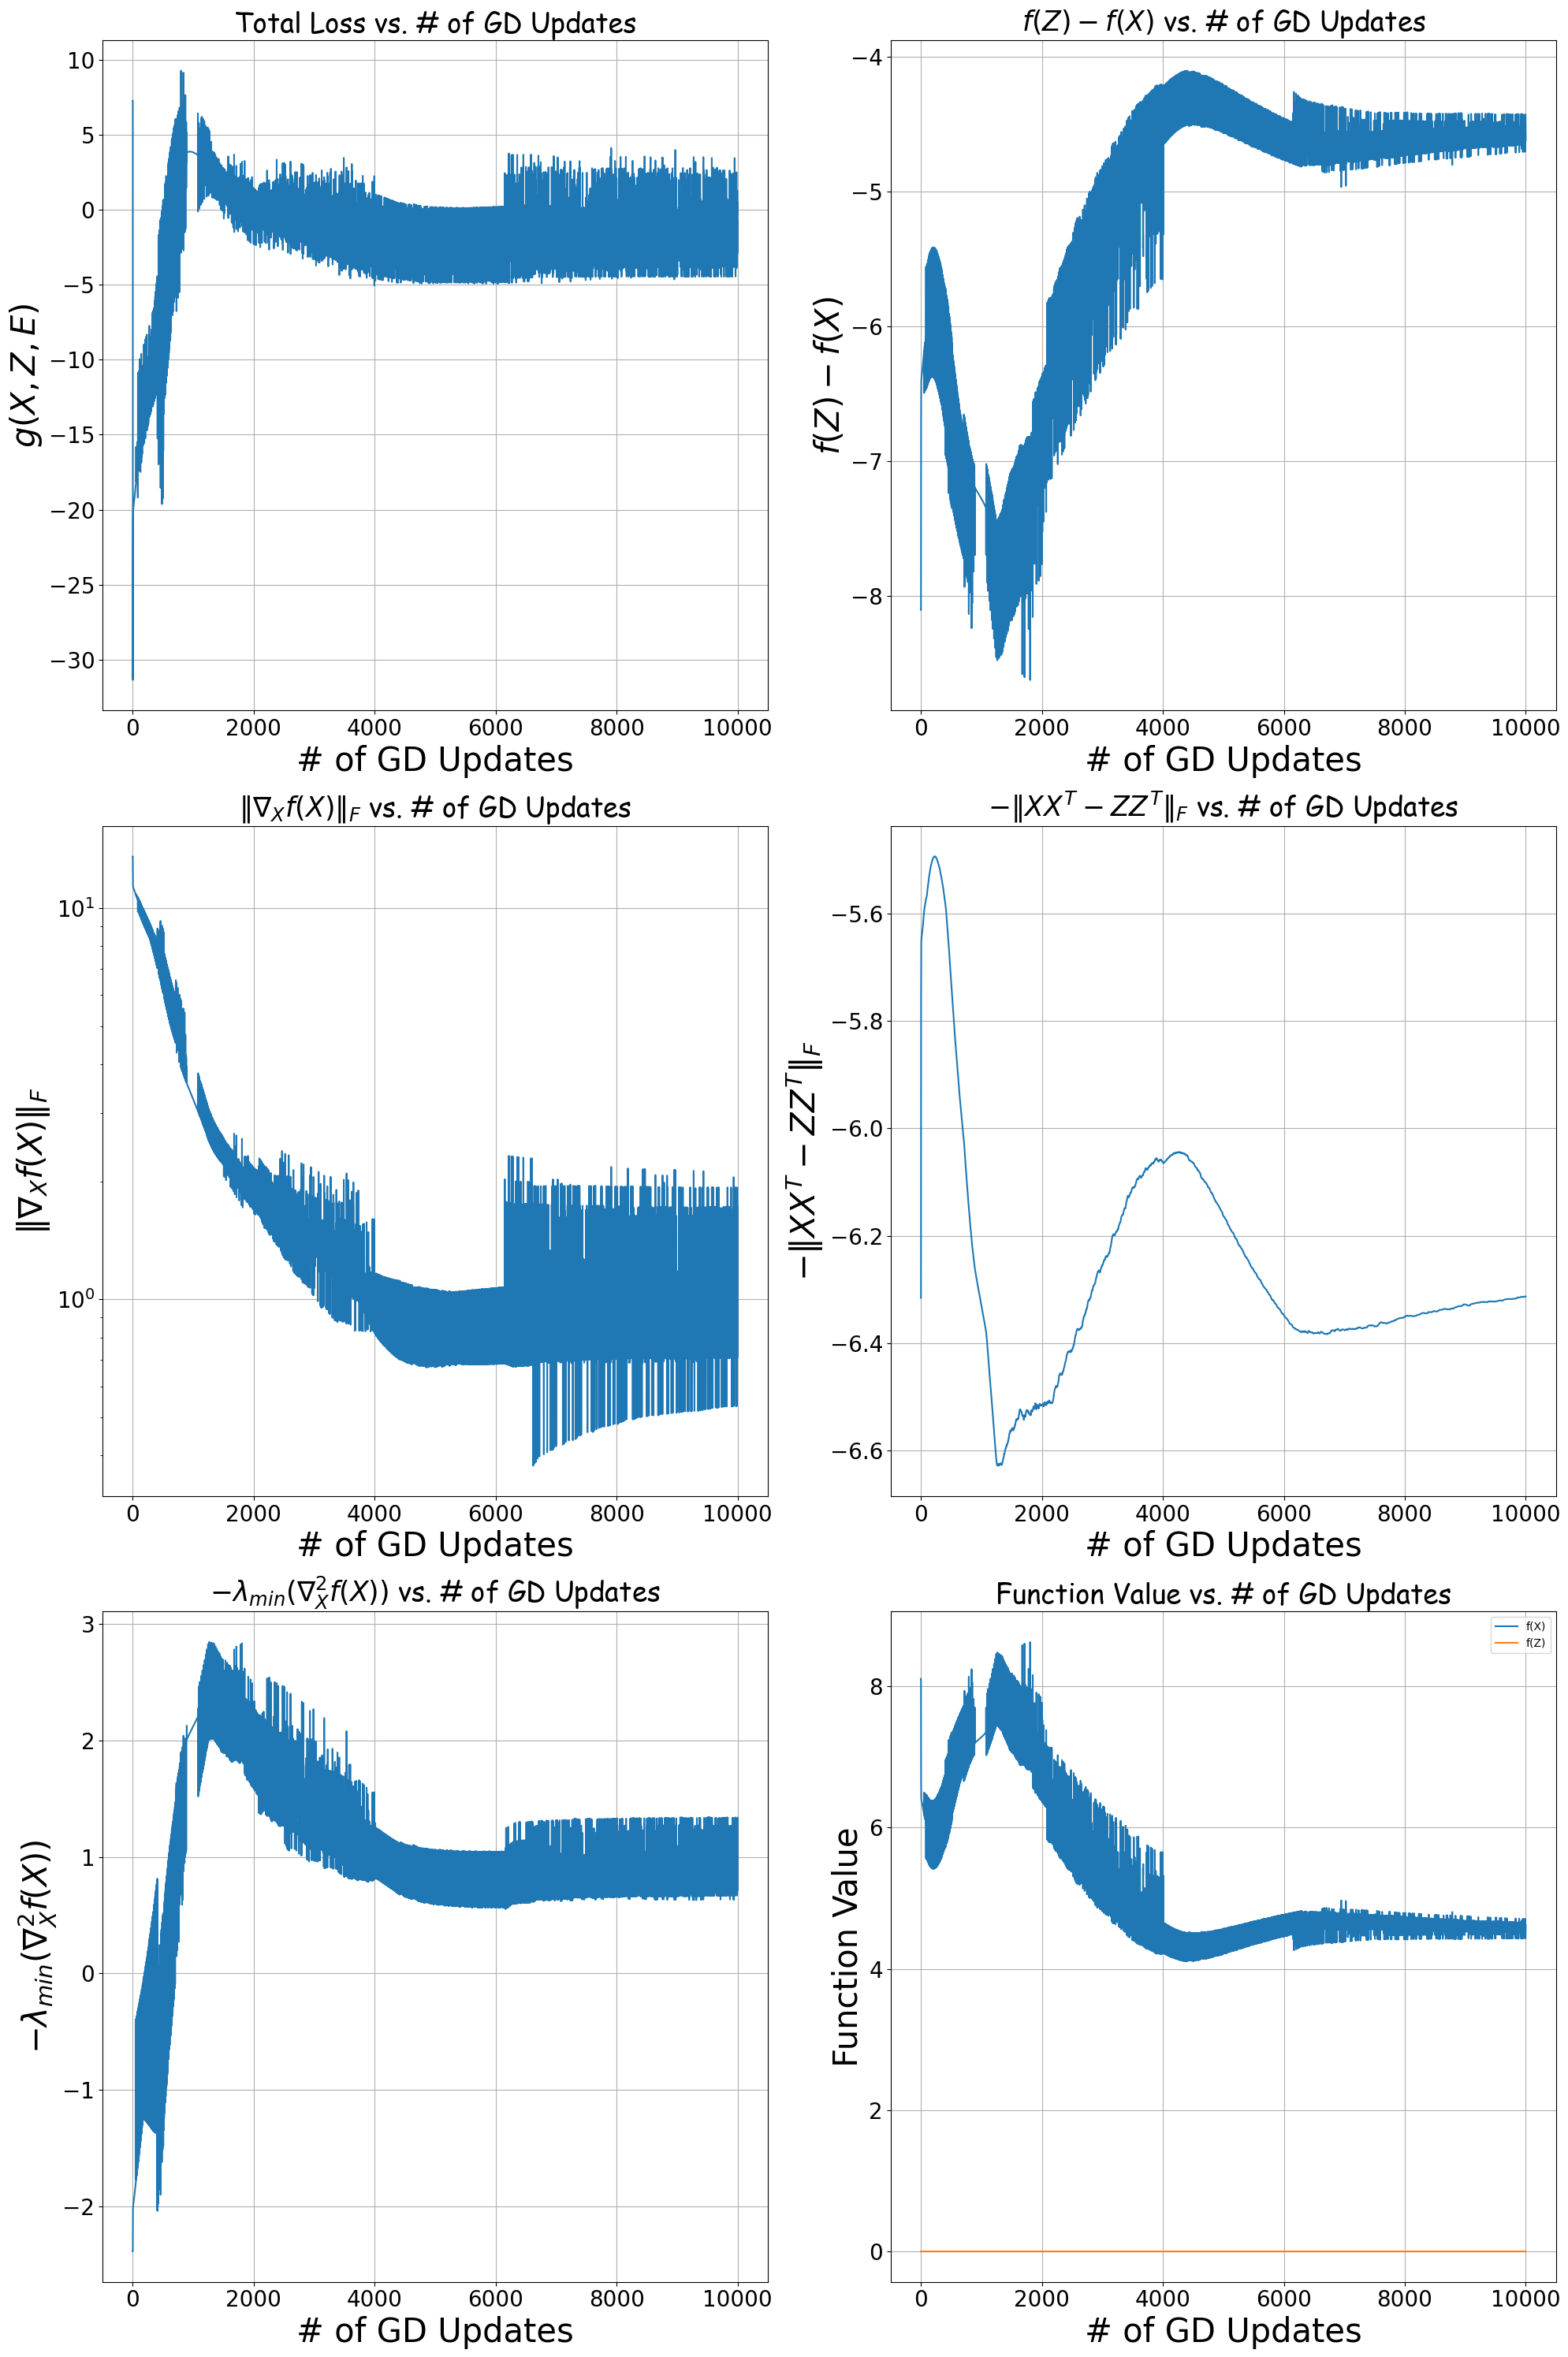

In [5]:
######## Search for (X, Z, P) ########
n           = 5
r           = 1
p           = 0.8
mu          = 2   # [1, n/r]
e_norm      = 1e-9
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e2)
top_k       = int(n * n * p)

same_seed(0)
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "P": None,
}
parameters, losses = compute_X_Z_e(
    variables,
    top_k,
    n, 
    r,  
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound
)

print_counter_MC("Search for (X, Z)", top_k, parameters, losses)
plot_loss(losses)

In [6]:
def DSE(top_k, search_loops, n, r, mu, e_norm, search_P=False, loss_type='A', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1e-1, -1e2)):
    same_seed(0)
    for i in range(search_loops):
        if search_P:
            P = None
        else:
            P = create_mask(torch.tensor(sample_mask(n, n, p)), top_k).to(torch.float32)
        variables = {
            "X": None,
            "Z": None,
            "e": None,
            "P": P,
        }
        parameters, losses = compute_X_Z_e(
            variables,
            top_k,
            n, 
            r,  
            mu,
            e_norm, 
            loss_type, 
            optim, 
            iters, 
            lr, 
            min_lr,
            lr_sched,
            T,
            trans_bound
        ) 
        if len(losses) < iters + 1: # Early Stop
            continue
        print_counter_MC(f"Search Loop {i}", top_k, parameters, losses, P=P)
        flag = check_MC(
            parameters,
            top_k,
            mu, 
            PSD=True,
            P=P
        )
        

In [7]:
n           = 5
r           = 1
p           = 0.4
mu          = 2   # [1, n/r]
e_norm      = 1e-18
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 2e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e2)
sear_loops  = 10
top_k       = int(n * n * p)
search_P    = True

DSE(
    top_k,
    sear_loops, 
    n, 
    r, 
    mu, 
    e_norm, 
    search_P,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr, 
    lr_sched, 
    T, 
    trans_bound
)

==================== Search Loop 0 ====================
=> # of samples (m)         =         10
=> Total loss               =   7.47e-02
=> f(Z) - f(X)              =  -7.48e-01
=> |gradient(X)|            =   4.17e-01
=> -lambda_min(hessian(X))  =   4.17e-01
=> |XX^T-ZZ^T|_F            =  -4.13e+00
=> X =
tensor([[ 0.5325],
        [-0.2579],
        [-0.8577],
        [-0.1326],
        [-0.8577]])
=> Z =
tensor([[-1.2996],
        [ 0.1923],
        [ 1.1241],
        [-1.1020],
        [-0.1367]])
=> P =
tensor([[0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.],
        [1., 1., 0., 1., 0.]])
=> Mask =
tensor([[0, 1, 1, 0, 0],
        [1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [1, 1, 0, 1, 0]])


(Convex) Distance to ground truth = 3.38e+00 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 5.39e+00 > 1e-6, thus FAILED :(


==================== Search Loop 1 ====================
=> # of samples (m)         =         10
=> Total loss               =  -2.29e-01
=> f(Z) - f(X)              =  -4.72e-01
=> |gradient(X)|            =   1.88e-01
=> -lambda_min(hessian(X))  =   1.88e-01
=> |XX^T-ZZ^T|_F            =  -3.76e+00
=> X =
tensor([[-0.7663],
        [ 0.8239],
        [-0.4420],
        [ 0.4538],
        [-0.1724]])
=> Z =
tensor([[-0.9040],
        [-0.8315],
        [ 0.5308],
        [-1.1801],
        [-0.5465]])
=> P =
tensor([[1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0.]])
=> Mask =
tensor([[1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1],
        [0, 0, 1, 0, 1],
        [1, 0, 0, 0, 0]])


(Convex) Distance to ground truth = 1.89e+00 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 1.85e-04 > 1e-6, thus FAILED :(


==================== Search Loop 2 ====================
=> # of samples (m)         =         10
=> Total loss               =  -8.41e-01
=> f(Z) - f(X)              =  -1.26e+00
=> |gradient(X)|            =   4.28e-01
=> -lambda_min(hessian(X))  =   4.28e-01
=> |XX^T-ZZ^T|_F            =  -4.80e+00
=> X =
tensor([[ 0.1126],
        [ 0.7614],
        [ 0.6001],
        [ 0.6890],
        [-0.2463]])
=> Z =
tensor([[ 1.3537],
        [-1.0703],
        [-0.6365],
        [ 1.0015],
        [-0.4416]])
=> P =
tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1.]])
=> Mask =
tensor([[0, 0, 1, 0, 0],
        [0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [1, 0, 1, 1, 1]])


(Convex) Distance to ground truth = 2.84e+00 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 1.89e-04 > 1e-6, thus FAILED :(


==================== Search Loop 3 ====================
=> # of samples (m)         =         10
=> Total loss               =  -9.74e-02
=> f(Z) - f(X)              =  -6.50e-02
=> |gradient(X)|            =   7.51e-02
=> -lambda_min(hessian(X))  =   7.51e-02
=> |XX^T-ZZ^T|_F            =  -1.21e+00
=> X =
tensor([[ 0.6585],
        [-0.3113],
        [ 0.2804],
        [ 0.6585],
        [-0.2028]])
=> Z =
tensor([[-0.0794],
        [-0.4496],
        [-0.1174],
        [ 0.6036],
        [-0.6254]])
=> P =
tensor([[0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])
=> Mask =
tensor([[0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0]])


(Convex) Distance to ground truth = 2.03e-01 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 4.44e-05 > 1e-6, thus FAILED :(


==================== Search Loop 4 ====================
=> # of samples (m)         =         10
=> Total loss               =  -2.66e-02
=> f(Z) - f(X)              =  -8.66e-03
=> |gradient(X)|            =   2.07e-02
=> -lambda_min(hessian(X))  =   2.06e-02
=> |XX^T-ZZ^T|_F            =  -6.11e-01
=> X =
tensor([[ 0.1367],
        [-0.0752],
        [-0.0609],
        [-0.2191],
        [-0.2169]])
=> Z =
tensor([[-0.2236],
        [ 0.4964],
        [-0.4964],
        [ 0.2683],
        [ 0.0342]])
=> P =
tensor([[1., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0.]])
=> Mask =
tensor([[1, 0, 1, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [1, 0, 1, 1, 0]])


(Convex) Distance to ground truth = 5.43e-01 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 1.02e-01 > 1e-6, thus FAILED :(


==================== Search Loop 5 ====================
=> # of samples (m)         =         10
=> Total loss               =  -4.79e-01
=> f(Z) - f(X)              =  -4.29e-02
=> |gradient(X)|            =   3.81e-02
=> -lambda_min(hessian(X))  =   3.81e-02
=> |XX^T-ZZ^T|_F            =  -2.32e+00
=> X =
tensor([[-0.2565],
        [-0.3682],
        [ 0.5585],
        [ 0.5129],
        [ 0.0575]])
=> Z =
tensor([[-0.2022],
        [-0.9373],
        [-0.9373],
        [ 0.5506],
        [-0.3081]])
=> P =
tensor([[1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 1., 1., 1.]])
=> Mask =
tensor([[1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 1, 1],
        [1, 0, 1, 1, 1]])


(Convex) Distance to ground truth = 2.03e+00 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 4.65e-01 > 1e-6, thus FAILED :(


==================== Search Loop 6 ====================
=> # of samples (m)         =         10
=> Total loss               =  -2.84e+00
=> f(Z) - f(X)              =  -4.01e+00
=> |gradient(X)|            =   4.64e-01
=> -lambda_min(hessian(X))  =   4.64e-01
=> |XX^T-ZZ^T|_F            =  -8.12e+00
=> X =
tensor([[-0.6263],
        [-0.1096],
        [ 0.9066],
        [ 1.2877],
        [-1.1229]])
=> Z =
tensor([[-0.5343],
        [-0.9042],
        [ 1.4769],
        [ 1.2578],
        [ 1.5762]])
=> P =
tensor([[0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
=> Mask =
tensor([[0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])


(Convex) Distance to ground truth = 7.90e-04 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 6.25e+00 > 1e-6, thus FAILED :(


KeyboardInterrupt: 